In [2]:
!pip install pymc3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 69.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of pymc3 to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 39.4 MB/s eta 0:00:00
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529958 sha256=a33edaea214eee50fd7956b202915a7d47161c551bd60b112d76dc036b4df573
  Stored in directory: /root/.cache/pip/wheels/fb/d3/25/6c443075ee21f3b6a59a6a180b55657b012722e1b89f8ccbe8
Successfully built theano-pymc


In [4]:
# Install the latest version of pymc
!pip install pymc arviz

import numpy as np
import pandas as pd
import pymc as pm # Changed from pymc3 to pymc
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pytensor.tensor as tt # Imported for sigmoid

# 1. Simulate dataset
np.random.seed(42)
n_samples = 100

# Simulate vulnerability scores (0-10)
vuln_score = np.random.beta(a=2, b=5, size=n_samples) * 10

# Simulate security investment (in $k, 10-100)
security_investment = np.random.uniform(10, 100, size=n_samples)

# Probability of attack increases with vulnerability, decreases with investment
# Using a logistic function for attack probability
logit_p_attack = 0.5 * vuln_score - 0.03 * security_investment - 2
p_attack = 1 / (1 + np.exp(-logit_p_attack))

attack_occurred = np.random.binomial(1, p_attack)

# Financial loss (only if attack occurs), otherwise 0
# Loss depends on vulnerability and is log-normally distributed
loss_mu = 6 + 0.1 * vuln_score
loss_sigma = 0.8
financial_loss = np.where(
    attack_occurred == 1,
    np.random.lognormal(mean=loss_mu, sigma=loss_sigma, size=n_samples),
    0
)

data = pd.DataFrame({
    "VulnerabilityScore": vuln_score,
    "SecurityInvestment": security_investment,
    "AttackOccurred": attack_occurred,
    "FinancialLoss": financial_loss
})

# 2. Bayesian Model for Attack Probability
with pm.Model() as model:
    # Priors
    beta_vuln = pm.Normal("beta_vuln", mu=0, sigma=1)
    beta_invest = pm.Normal("beta_invest", mu=0, sigma=1)
    intercept = pm.Normal("intercept", mu=0, sigma=2)

    # Likelihood
    # Use pytensor.tensor for the sigmoid function
    logit_p = (beta_vuln * data["VulnerabilityScore"] +
               beta_invest * data["SecurityInvestment"] +
               intercept)
    p = pm.Deterministic("p", tt.sigmoid(logit_p))
    attack = pm.Bernoulli("attack", p=p, observed=data["AttackOccurred"])

    # Posterior
    # The sample function arguments are slightly different in pymc v5
    trace = pm.sample(1000, tune=1000, cores=1, return_inferencedata=True, progressbar=False)


# 3. Quantify Risk: Expected Financial Loss
expected_loss = np.mean(data["FinancialLoss"])
prob_attack = data["AttackOccurred"].mean()
# Handle the case where no attacks occurred to avoid division by zero or empty slice
cond_loss = data[data["AttackOccurred"] == 1]["FinancialLoss"]
if not cond_loss.empty:
    cond_loss = cond_loss.mean()
else:
    cond_loss = 0.0 # Or np.nan, depending on desired behavior

print("Probability of attack (empirical):", prob_attack)
print("Average financial loss (overall): $", round(expected_loss, 2))
print("Average financial loss (if attacked): $", round(cond_loss, 2))

# 4. Train logistic regression as a baseline and measure accuracy
X = data[["VulnerabilityScore", "SecurityInvestment"]]
y = data["AttackOccurred"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Baseline attack occurrence prediction accuracy:", accuracy)

# 5. Summarize Bayesian model results
print(az.summary(trace, var_names=["beta_vuln", "beta_invest", "intercept"]))

Probability of attack (empirical): 0.1
Average financial loss (overall): $ 79.68
Average financial loss (if attacked): $ 796.79
Baseline attack occurrence prediction accuracy: 0.85
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_vuln    0.492  0.248   0.070    0.986      0.009    0.007     840.0   
beta_invest -0.062  0.019  -0.099   -0.029      0.001    0.001     896.0   
intercept   -0.884  0.804  -2.492    0.628      0.027    0.027     889.0   

             ess_tail  r_hat  
beta_vuln       695.0    1.0  
beta_invest     941.0    1.0  
intercept       661.0    1.0  


#Distribution of Simulated Variables

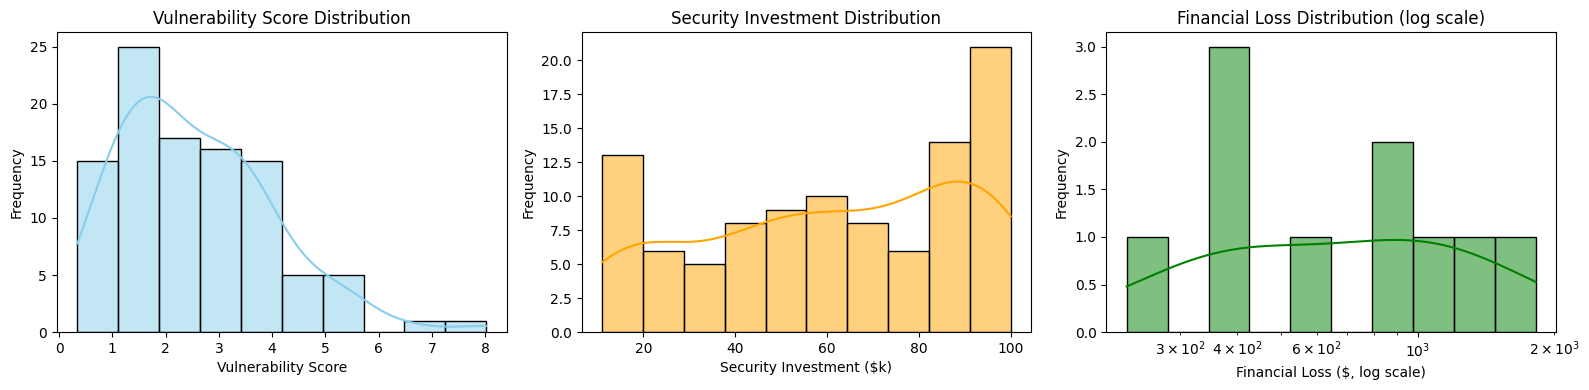

<ipython-input-5-1028638036>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="AttackOccurred", data=data, palette="Set2")


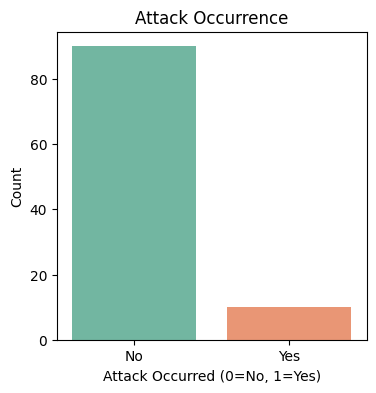

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'data' is your DataFrame from the simulation step
# data = pd.DataFrame({...})  # As previously created

plt.figure(figsize=(16, 4))

# Histogram: Vulnerability Score
plt.subplot(1, 3, 1)
sns.histplot(data["VulnerabilityScore"], bins=10, kde=True, color='skyblue')
plt.title("Vulnerability Score Distribution")
plt.xlabel("Vulnerability Score")
plt.ylabel("Frequency")

# Histogram: Security Investment
plt.subplot(1, 3, 2)
sns.histplot(data["SecurityInvestment"], bins=10, kde=True, color='orange')
plt.title("Security Investment Distribution")
plt.xlabel("Security Investment ($k)")
plt.ylabel("Frequency")

# Histogram: Financial Loss (use log scale for better visualization)
plt.subplot(1, 3, 3)
# Avoid log(0) by filtering out zeros
nonzero_loss = data.loc[data["FinancialLoss"] > 0, "FinancialLoss"]
sns.histplot(nonzero_loss, bins=10, kde=True, color='green', log_scale=True)
plt.title("Financial Loss Distribution (log scale)")
plt.xlabel("Financial Loss ($, log scale)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Bar plot: Attack Occurrence
plt.figure(figsize=(4, 4))
sns.countplot(x="AttackOccurred", data=data, palette="Set2")
plt.title("Attack Occurrence")
plt.xlabel("Attack Occurred (0=No, 1=Yes)")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

Purpose:

Shows the range, skewness, and spread of the simulated environment.
(c): Demonstrates how the simulated environment can reflect Zimbabwe industry scenarios by adjusting these distributions to match real data.


#Attack Probability Model Fit

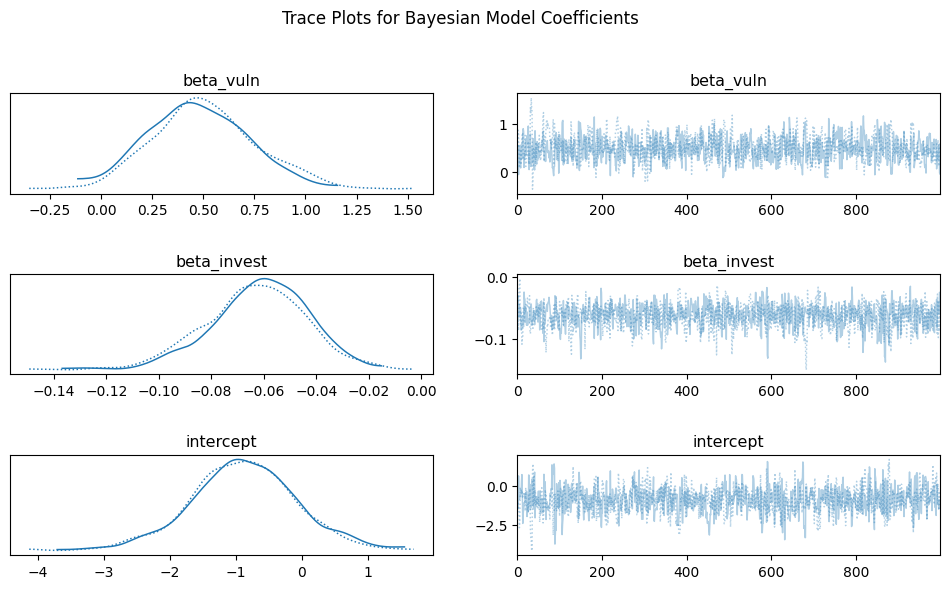

<ipython-input-11-3752673556>:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = posterior_samples.dims["draw"]


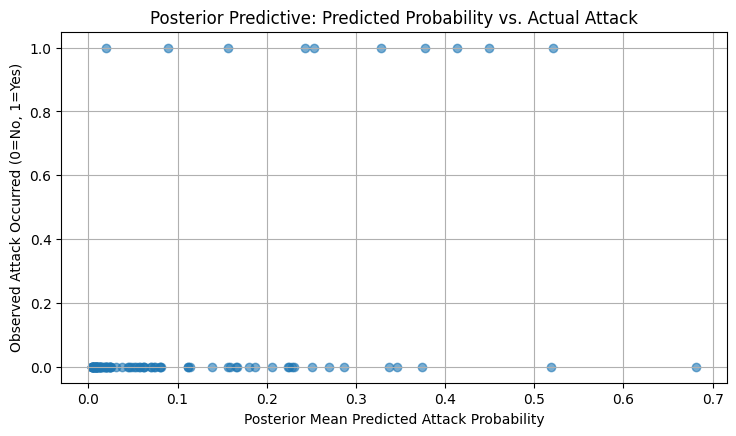

In [11]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# Trace plots for Bayesian model coefficients
az.plot_trace(trace, var_names=["beta_vuln", "beta_invest", "intercept"])
plt.suptitle("Trace Plots for Bayesian Model Coefficients", y=1.02)
plt.subplots_adjust(hspace=0.8)  # <-- Adds vertical space between subplots
plt.show()

# Posterior predictive plot: predicted attack probability vs actual attacks

# Get posterior samples for the linear predictor
posterior_samples = trace.posterior
n_draws = posterior_samples.dims["draw"]

# Compute posterior mean probabilities for all observations
beta_vuln_samples = posterior_samples["beta_vuln"].values.reshape(-1, 1)
beta_invest_samples = posterior_samples["beta_invest"].values.reshape(-1, 1)
intercept_samples = posterior_samples["intercept"].values.reshape(-1, 1)

# Shape: (n_draws, n_obs)
logit_p_samples = (beta_vuln_samples * data["VulnerabilityScore"].values +
                   beta_invest_samples * data["SecurityInvestment"].values +
                   intercept_samples)

p_samples = 1 / (1 + np.exp(-logit_p_samples))

# Posterior mean attack probability for each observation
p_mean = p_samples.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.scatter(p_mean, data["AttackOccurred"], alpha=0.6, label="Observed Attacks", color="tab:blue")
plt.xlabel("Posterior Mean Predicted Attack Probability")
plt.ylabel("Observed Attack Occurred (0=No, 1=Yes)")
plt.title("Posterior Predictive: Predicted Probability vs. Actual Attack")
plt.grid(True)
plt.tight_layout(pad=3.0)  # Add padding inside the figure
plt.show()


Purpose:

(a): Shows uncertainty and learning of the Bayesian model parameters.
(b): Visualizes how well the model fits and predicts real outcomes.

#Calibration Curve / Reliability Diagram

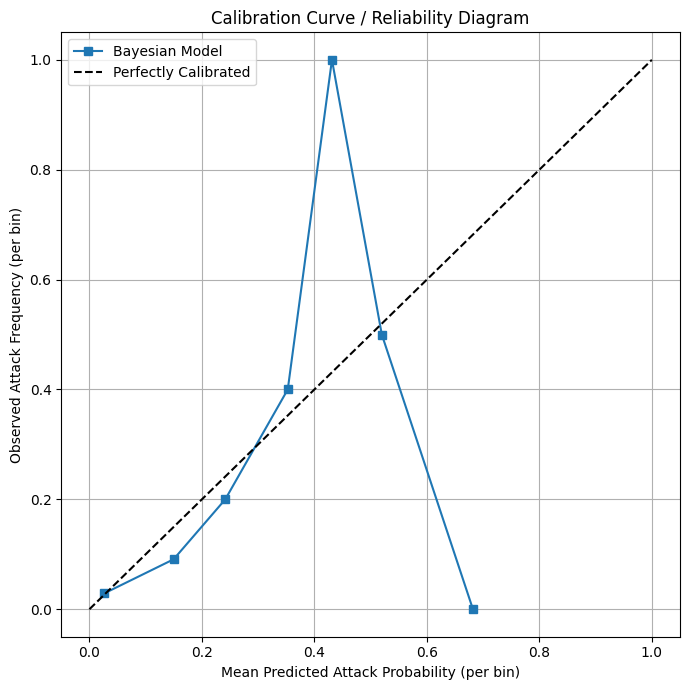

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Use the posterior mean predicted probabilities from your Bayesian model
# p_mean = ... (already computed previously)

# Use the true attack outcomes
y_true = data["AttackOccurred"].values

# Compute calibration curve (binning into 10 bins)
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true, p_mean, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(7, 7))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Bayesian Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Attack Probability (per bin)")
plt.ylabel("Observed Attack Frequency (per bin)")
plt.title("Calibration Curve / Reliability Diagram")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Purpose:

(a, b): Demonstrates if the Bayesian probability estimates are well-calibrated and trustworthy for decision-making.

#Receiver Operating Characteristic (ROC) Curve.

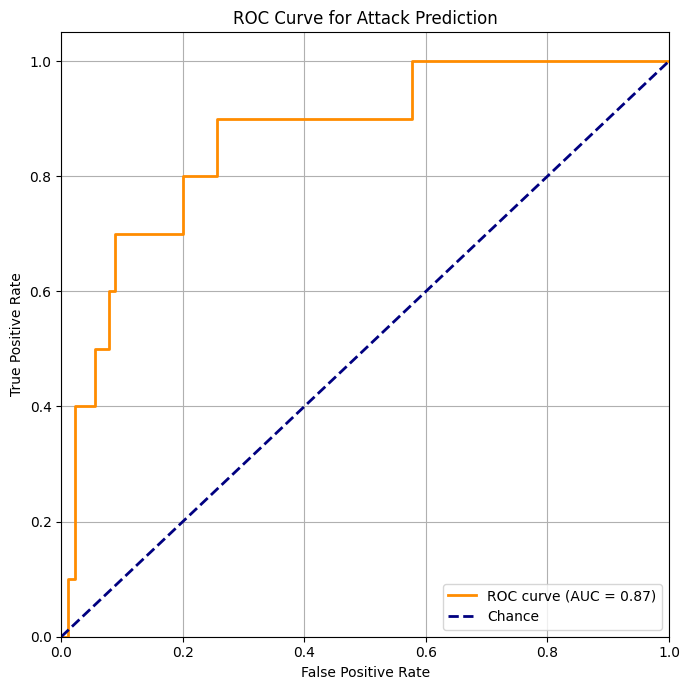

AUC (Area Under Curve): 0.867


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_true: actual attack outcomes (0 or 1)
y_true = data["AttackOccurred"].values

# y_score: posterior mean predicted probability from Bayesian model (already computed as p_mean)
# p_mean = ...

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, p_mean)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Attack Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC (Area Under Curve): {roc_auc:.3f}")

Purpose:

(b): Quantifies and visually displays predictive accuracy and discrimination of the model.

(a): Shows how Bayesian predictions improve practical risk classification.


#Posterior Distribution of Key Parameters.

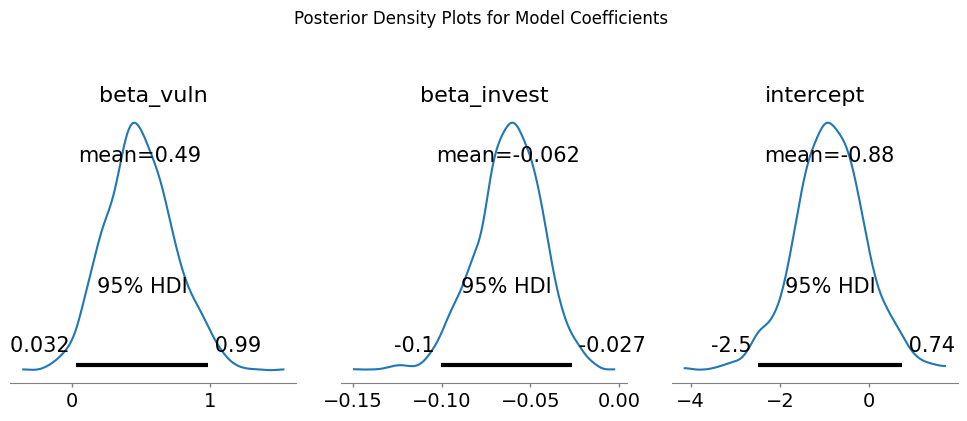

In [15]:
import arviz as az
import matplotlib.pyplot as plt

# Density plots for posterior distributions of model coefficients using ArviZ
az.plot_posterior(
    trace,
    var_names=["beta_vuln", "beta_invest", "intercept"],
    hdi_prob=0.95,
    kind='kde',
    figsize=(10, 4),
    textsize=14
)
plt.suptitle("Posterior Density Plots for Model Coefficients", y=1.04)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Purpose:

(a, c): Shows the range of plausible values for how investment and vulnerability affect risk, supporting actionable recommendations for Zimbabwean stakeholders.


#Expected Financial Loss.

<ipython-input-16-1849794214>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="AttackOccurred", y="FinancialLoss", data=data, palette="Set2", cut=0, inner="quartile", scale="width")
<ipython-input-16-1849794214>:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="AttackOccurred", y="FinancialLoss", data=data, palette="Set2", cut=0, inner="quartile", scale="width")


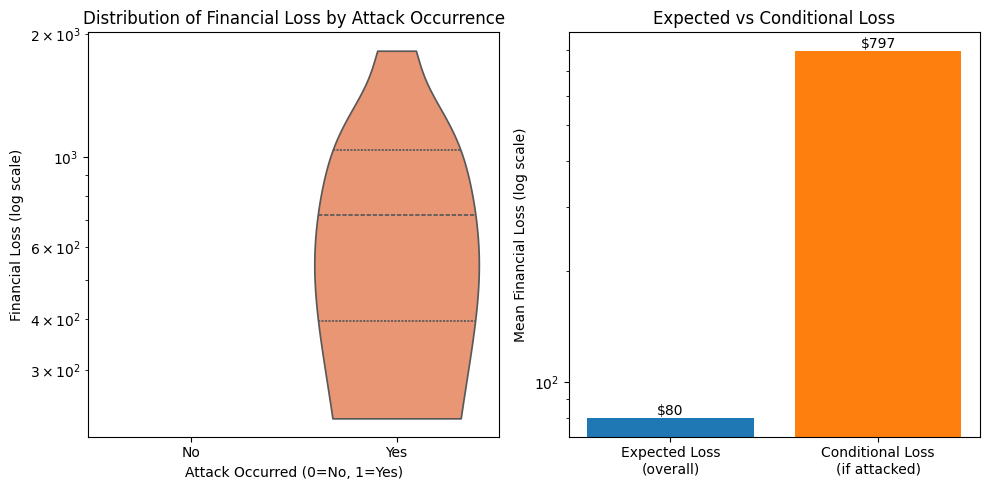

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Box/violin plot: Distribution of financial loss, split by attack occurrence
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.violinplot(x="AttackOccurred", y="FinancialLoss", data=data, palette="Set2", cut=0, inner="quartile", scale="width")
plt.yscale('log')
plt.xlabel("Attack Occurred (0=No, 1=Yes)")
plt.ylabel("Financial Loss (log scale)")
plt.title("Distribution of Financial Loss by Attack Occurrence")
plt.xticks([0, 1], ["No", "Yes"])

# Bar plot: Expected loss (mean) and conditional loss (mean, given attack)
expected_loss = data["FinancialLoss"].mean()
conditional_loss = data.loc[data["AttackOccurred"] == 1, "FinancialLoss"].mean()

plt.subplot(1, 2, 2)
bars = plt.bar(["Expected Loss\n(overall)", "Conditional Loss\n(if attacked)"],
        [expected_loss, conditional_loss],
        color=["tab:blue", "tab:orange"])
plt.yscale('log')
plt.ylabel("Mean Financial Loss (log scale)")
plt.title("Expected vs Conditional Loss")
for bar, val in zip(bars, [expected_loss, conditional_loss]):
    plt.text(bar.get_x() + bar.get_width()/2, val, f"${val:,.0f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Purpose:

(a, c): Gives an intuitive view of potential financial consequences, supporting risk communication.

#Partial Dependence / Effect Plots.

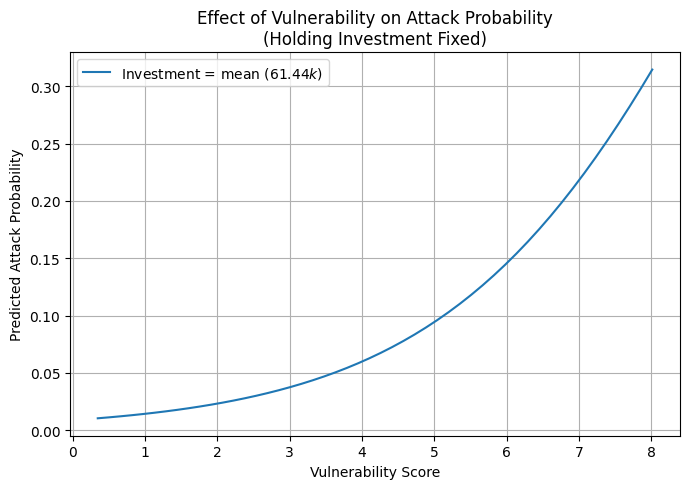

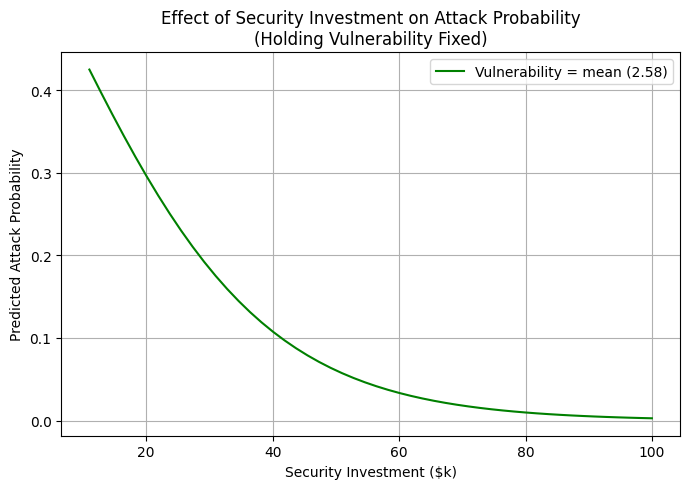

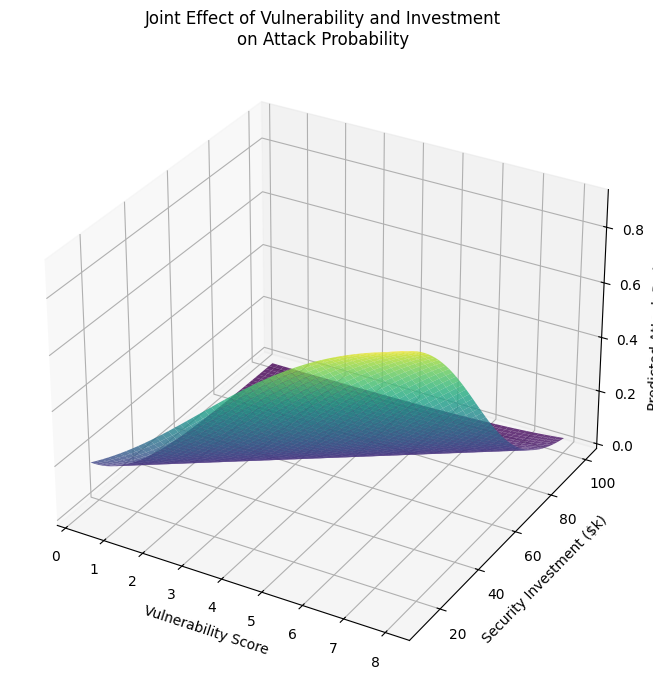

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assume trace (posterior samples) and data are available

# Settings for grid
vuln_grid = np.linspace(data["VulnerabilityScore"].min(), data["VulnerabilityScore"].max(), 50)
invest_grid = np.linspace(data["SecurityInvestment"].min(), data["SecurityInvestment"].max(), 50)

# Use posterior mean for each coefficient
beta_vuln = trace.posterior["beta_vuln"].mean().item()
beta_invest = trace.posterior["beta_invest"].mean().item()
intercept = trace.posterior["intercept"].mean().item()

# 1. Line plot: Effect of Vulnerability at mean Investment
mean_invest = data["SecurityInvestment"].mean()
logit_p_vuln = beta_vuln * vuln_grid + beta_invest * mean_invest + intercept
p_vuln = 1 / (1 + np.exp(-logit_p_vuln))

plt.figure(figsize=(7, 5))
plt.plot(vuln_grid, p_vuln, label=f"Investment = mean (${mean_invest:,.2f}k$)")
plt.xlabel("Vulnerability Score")
plt.ylabel("Predicted Attack Probability")
plt.title("Effect of Vulnerability on Attack Probability\n(Holding Investment Fixed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Line plot: Effect of Investment at mean Vulnerability
mean_vuln = data["VulnerabilityScore"].mean()
logit_p_invest = beta_vuln * mean_vuln + beta_invest * invest_grid + intercept
p_invest = 1 / (1 + np.exp(-logit_p_invest))

plt.figure(figsize=(7, 5))
plt.plot(invest_grid, p_invest, color="green", label=f"Vulnerability = mean ({mean_vuln:,.2f})")
plt.xlabel("Security Investment ($k)")
plt.ylabel("Predicted Attack Probability")
plt.title("Effect of Security Investment on Attack Probability\n(Holding Vulnerability Fixed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Surface plot: Joint effect of Vulnerability and Investment
from mpl_toolkits.mplot3d import Axes3D

Vuln, Invest = np.meshgrid(vuln_grid, invest_grid)
logit_p_surface = beta_vuln * Vuln + beta_invest * Invest + intercept
p_surface = 1 / (1 + np.exp(-logit_p_surface))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Vuln, Invest, p_surface, cmap="viridis", alpha=0.8)
ax.set_xlabel("Vulnerability Score")
ax.set_ylabel("Security Investment ($k)")
ax.set_zlabel("Predicted Attack Probability")
ax.set_title("Joint Effect of Vulnerability and Investment\non Attack Probability")
plt.tight_layout()
plt.show()

Purpose:

(a, c): Explains how risk changes as a function of key variables, guiding risk mitigation in Zimbabwean context.

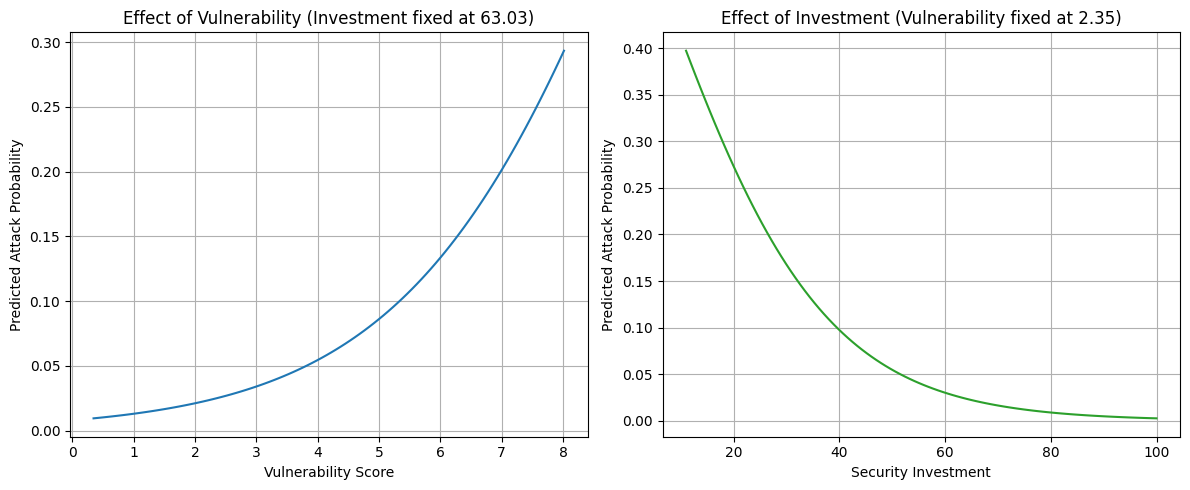

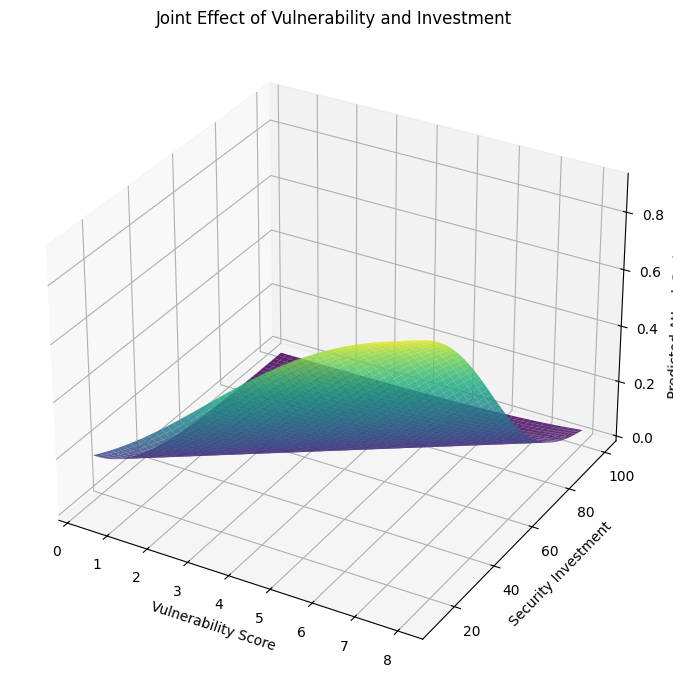

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you have the posterior mean estimates for coefficients:
# (If you want to use the mean, median, or sample from the posterior, adjust as needed)
beta_vuln = trace.posterior["beta_vuln"].mean().item()
beta_invest = trace.posterior["beta_invest"].mean().item()
intercept = trace.posterior["intercept"].mean().item()

# 1. Line plots: Effect of Vulnerability (vary vulnerability, fix investment)
vuln_range = np.linspace(data["VulnerabilityScore"].min(), data["VulnerabilityScore"].max(), 100)
invest_fixed = data["SecurityInvestment"].median()
logit_vary_vuln = intercept + beta_vuln * vuln_range + beta_invest * invest_fixed
prob_vary_vuln = 1 / (1 + np.exp(-logit_vary_vuln))

# 2. Line plots: Effect of Investment (vary investment, fix vulnerability)
invest_range = np.linspace(data["SecurityInvestment"].min(), data["SecurityInvestment"].max(), 100)
vuln_fixed = data["VulnerabilityScore"].median()
logit_vary_invest = intercept + beta_vuln * vuln_fixed + beta_invest * invest_range
prob_vary_invest = 1 / (1 + np.exp(-logit_vary_invest))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(vuln_range, prob_vary_vuln, color="tab:blue")
plt.xlabel("Vulnerability Score")
plt.ylabel("Predicted Attack Probability")
plt.title(f"Effect of Vulnerability (Investment fixed at {invest_fixed:.2f})")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(invest_range, prob_vary_invest, color="tab:green")
plt.xlabel("Security Investment")
plt.ylabel("Predicted Attack Probability")
plt.title(f"Effect of Investment (Vulnerability fixed at {vuln_fixed:.2f})")
plt.grid(True)

plt.tight_layout()
plt.show()

# 3. Surface plot: Joint Effect of Vulnerability and Investment
from mpl_toolkits.mplot3d import Axes3D

vuln_grid, invest_grid = np.meshgrid(
    np.linspace(data["VulnerabilityScore"].min(), data["VulnerabilityScore"].max(), 50),
    np.linspace(data["SecurityInvestment"].min(), data["SecurityInvestment"].max(), 50)
)
logit_surface = intercept + beta_vuln * vuln_grid + beta_invest * invest_grid
prob_surface = 1 / (1 + np.exp(-logit_surface))

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(
    vuln_grid, invest_grid, prob_surface,
    cmap='viridis', edgecolor='none', alpha=0.85
)
ax.set_xlabel('Vulnerability Score')
ax.set_ylabel('Security Investment')
ax.set_zlabel('Predicted Attack Probability')
ax.set_title('Joint Effect of Vulnerability and Investment')
plt.tight_layout()
plt.show()

#Posterior Predictive Checks.

Purpose:

(b): Validates model adequacy and fit, showing if Bayesian model can reproduce data characteristics.